# Modules

In [1]:
from time import time
from datetime import timedelta
from IPython.display import clear_output

import numpy as np
from scipy.signal import argrelextrema, find_peaks

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, rgb2hex

from mesa import Agent, Model
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter

# Helper functions
Obtain the sum of the fractions across all FSM's in the CA.

In [12]:
def get_sus(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0]
    return state

def get_exp(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[1]
    return state

def get_inf(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[2]
    return state

def get_rec(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[3]
    return state

# CA class
* Set all parameters as "global" parameters, i.e., all FSMs have the same params.
* Set a global time t (days)
* Random give some FSMs a state $(0.8, 0, 0.2, 0)$ instead of $(1, 0, 0, 0)$

In [10]:
class CellularAutomaton(Model):
    
    def __init__(
        self,
        height = 30,
        width = 30,
        mu = 0.0005, # Birth rate
        sig = 1/7,   # Rate of delay
        gam = 1/14,  # Rate of recovery
        c = 1/2,     # Connection factor between FSM
        b0 = 0.25,   # Rate of infection
        b1 = 0.2,    # Amplitude of seasonality of infection
        dt = 1,
        manual_init = False,    # Boolean, use if you want to specify initial conditions
        init_coords = None, # array of 2-tuples (sort by first value of tuple) representing coordinates for which to specify conditions
        init_states = None # array of same lentgh as coords with 4-tuples specifying SEIR proportions
    ):
        self.height = height
        self.width = width
        
        self.mu = mu
        self.b0 = b0
        self.b1 = b1
        self.sig = sig
        self.gam = gam
        self.c = c
        
        self.t = 0
        self.dt = dt
        self.manual_init = manual_init
        self.init_coords = init_coords
        self.init_states = init_states
        
        self.schedule = SimultaneousActivation(self)
        self.grid = Grid(self.width, self.height, torus=True)

        self.datacollector = DataCollector(
            model_reporters =  {
                "sus": get_sus,
                "exp": get_exp,
                "inf": get_inf,
                "rec": get_rec
                }
            )
        
        np.random.seed(0) # Get the same initial states
        count = 0
        
        # sets initial states if defined
        count = 0 # how many specified initial coordinates have been set
        if self.manual_init:
            for (contents, i, j) in self.grid.coord_iter():
                FSM = FSM_SEIR((i, j), self)
                if (i, j) in self.init_coords:
                    FSM.state = self.init_states[count]
                    count += 1
                else:
                    FSM.state = [0.0423, 0.003, 0.0021, 0.9704]
                self.grid.place_agent(FSM, (i,j))
                self.schedule.add(FSM)

                
        else:            
            for (contents, i, j) in self.grid.coord_iter():
                FSM = FSM_SEIR((i,j), self)

                if np.random.random() < 0.1:
                    FSM.state = [0]*4
                    FSM.state[0] = 0.8
                    FSM.state[2] = 0.2

                    count += 1
                else:
                    FSM.state = [0.0423, 0.003, 0.0021, 0.9704]
                self.grid.place_agent(FSM, (i,j))
                self.schedule.add(FSM)
        
        #print(f"\nR0 is approximately: {b0/(gam + mu)}.")
        #print(f"There are {count} FSMs with infected.")
        
        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.t += 1
        self.schedule.step()
        self.datacollector.collect(self)

    def run(self, n):
        for _ in range(n):
            self.step()

# FSM class

* States: $(S, I, E, R)$, where each of the attributes is a fraction of the form $\frac{n}{10000}, \quad n \in \mathbb{N}$. It follows that each FSM has $10001^4$ different states it can attain.
* Transition function:
$$ S_{i,j}^{t+1} = S_{i,j}^t - \beta(t) S_{i,j}^tI_{i,j}^t - c\beta(t)\sum_{k,l} I_{k,l}^t S_{i,j}^t + \mu (1 - S_{i,j}^t), $$
$$ E_{i,j}^{t+1} = E_{i,j}^t + \beta(t) S_{i,j}^tI_{i,j}^t + c\beta(t)\sum_{k,l} I_{k,l}^t S_{i,j}^t - \sigma E_{i,j}^t - \mu E_{i,j}^t,$$
$$ I_{i,j}^{t+1} = I_{i,j}^t + \sigma E_{i,j}^t - \gamma  I_{i,j}^t - \mu I_{i,j}^t, $$
$$ R_{i,j}^{t+1} = R_{i,j}^t + \gamma I_{i,j}^t - \mu R_{i,j}^t, $$
where $\beta(t) = \beta_0 (1 + \beta_1\cos(\omega t))$.

In [4]:
# Stau, Etau, Itau, Rtau = self.state[self.model.tau-1,:]
# + np.exp(- self.model.mu * self.model.tau) * (self.model.lam * Stau * Itau + sum([self.model.lam * self.model.m * x.state[self.model.tau-1,2] * Stau for x in neighbors]))
# self._nextState[1:,:] = self.state[:self.model.tau-1,:]
# self._nextState[0,:] = [S, E, I, R]

In [6]:
class FSM_SEIR(Agent):
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.x, self.y = pos

        self.state = None
        self._nextState = None
        self.counter = 0

    def step(self):
        neighbors = self.model.grid.get_neighbors((self.x,self.y), True)
        
        S,E,I,R = self.state
        
        F = 2*np.pi/100 # Period of temporal forcing
        omega = F
        
        beta = self.model.b0 * (1 + self.model.b1 * np.cos( omega * self.model.t))
        
        Snew = S - beta * S * I - sum([self.model.c * beta * x.state[2] * S for x in neighbors]) + self.model.mu * (1 - S)
        Enew = E + beta * S * I + sum([self.model.c * beta * x.state[2] * S for x in neighbors]) - E * self.model.sig - self.model.mu * E
        Inew = I + E * self.model.sig - I * self.model.gam - self.model.mu * I
        Rnew = R + I * self.model.gam - self.model.mu*R
        
        n = 4
        
        # Map to state space
        S = round(Snew, n)
        E = round(Enew, n)
        I = round(Inew, n)
        R = round(Rnew, n)
        
        self._nextState = [S, E, I, R]
        
    def advance(self):
        self.state = self._nextState

# Run model

<AxesSubplot:>

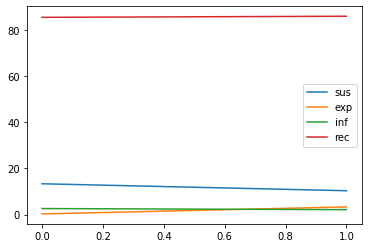

In [32]:
model = CellularAutomaton( 
        height = 10,
        width = 10,
        mu = 0.0005,  # Birth rate
        sig = 1/8,   # Rate of delay
        gam = 1/5,   # Rate of recovery
        c = 1/2,     # Connection factor between FSM
        b0 = 1,   # Rate of infection
        b1 = .005,     # Amplitude of seasonality of infection
)

model.run(100)
    
df = model.datacollector.get_model_vars_dataframe()
df.plot()

# Lyapunov exponent

<AxesSubplot:>

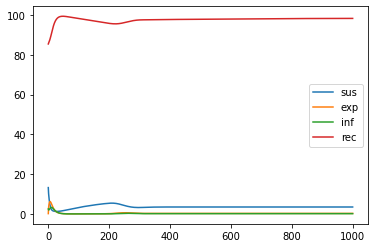

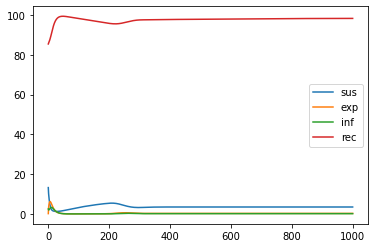

In [16]:
eps = 0.0001 # amount of peturbation
height = 10
width = 10
mu = 0.0005  # Birth rate
sig = 1/8  # Rate of delay
gam = 1/5   # Rate of recovery
c = 1/2     # Connection factor between FSM
b0 = 1   # Rate of infection
b1 = .005   # Amplitude of seasonality of infection

model = CellularAutomaton( 
        height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
        manual_init = False, init_coords = [(5, 5)], init_states = [(0.8, 0, 0.2, 0)]
)

model_eps = CellularAutomaton( 
        height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
        manual_init = False, init_coords = [(5, 5)], init_states = [(0.8-eps, 0, 0.2+eps, 0)] )

model.run(1000)
model_eps.run(1000)
    
df = model.datacollector.get_model_vars_dataframe()
df_eps = model_eps.datacollector.get_model_vars_dataframe()

df.plot()
df_eps.plot()

# Find peaks of the final dynamics

Number of unique peaks: 0


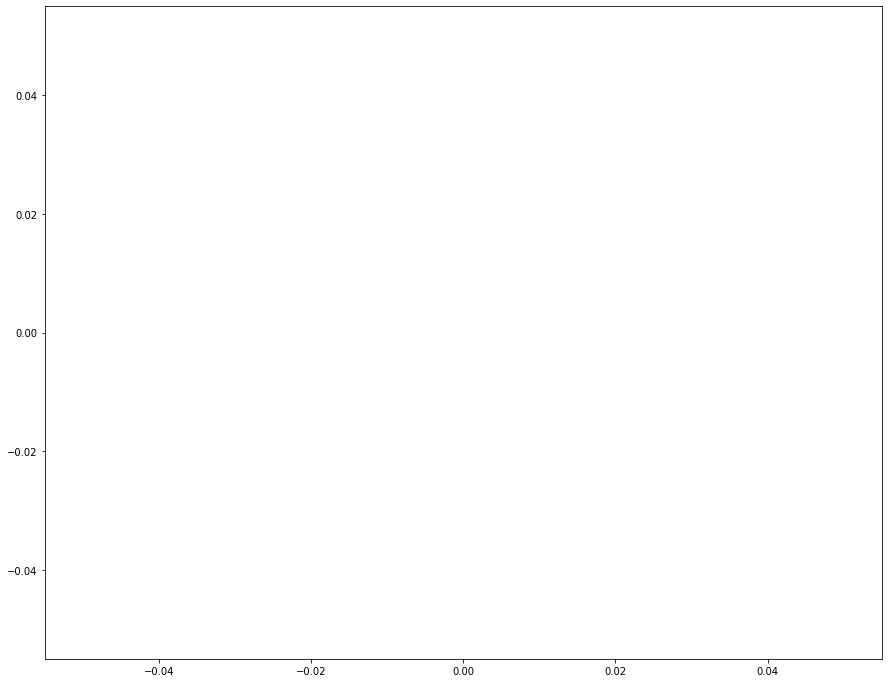

In [8]:
T = 2000
peaks, _ = find_peaks(df['inf'][T:].to_numpy())

print(f"Number of unique peaks: {len(df['inf'][peaks + T].unique())}")

plt.figure(figsize = (15, 12))
plt.plot(range(len(df['inf'][T:])), df['inf'][T:])
plt.scatter(peaks, df['inf'][T + peaks], color = 'r')
plt.show()

# Construct dict for bifucation diagram
* Times updates with each iteration of the loop
* For 20 different $b_1$, it takes about 2 hours

In [9]:
betas = np.linspace(.1, .6, 1001)
bifur = {}

start = time()

print(f"Time passed since start:    {timedelta(seconds = 0)}")
print(f"Estimate of remaining time: ??")
print(f"Percentage completion:      {0}%")

for i,b1 in enumerate(betas):
    clear_output(wait=True)
    
    model = CellularAutomaton( 
            height = 10,
            width = 10,
            mu = 0.0005,  # Birth rate
            sig = 1/8,   # Rate of delay
            gam = 1/5,   # Rate of recovery
            c = 1/2,     # Connection factor between FSM
            b0 = 1,   # Rate of infection
            b1 = b1,     # Amplitude of seasonality of infection
    )

    model.run(3000)

    df = model.datacollector.get_model_vars_dataframe()

    T = 2000
    peaks, _ = find_peaks(df['inf'][T:].to_numpy())
    
    bifur[b1] = df['inf'][T + peaks].unique()
    
    end = time()
    print(f"Time passed since start:    {timedelta(seconds = int(end - start))}")
    print(f"Estimate of remaining time: {timedelta(seconds = int((end - start) / (i+1) * (len(betas) - i - 1)))  }")
    print(f"Percentage completion:      {(i+1)/len(betas) * 100:.2f}%")

KeyboardInterrupt: 

In [ ]:
for item in bifur:
    plt.plot([item]*len(bifur[item]), (bifur[item]).tolist(), ls='', marker='.',color = 'k',)
    
plt.show()

# Plot density of infected

In [ ]:
import nolds

print(nolds.lyap_e(df['inf'][20:]))
print(nolds.lyap_r(df['inf']))

In [ ]:
infected = np.zeros((30,30))
for (content, i, j) in model.grid.coord_iter():
    infected[i,j] = content.state[2]

# Fourier Analysis

In [ ]:
infected = np.zeros((30,30))
for (content, i, j) in model.grid.coord_iter():
    if i==0:
        print(i, j, content.state)
    infected[i,j] = content.state[2]
print(infected)

# MESA server

In [ ]:
norm = Normalize(vmin=0, vmax = 0.5)
cmap = cm.Greys
m = cm.ScalarMappable(norm = norm, cmap = cmap)

colordict = {}

for i in np.linspace(0,1,10001):
    k = round(10000*i)/10000
    colordict[k] = rgb2hex(m.to_rgba(k))

def portrayCell(fsm):
    assert fsm is not None
    
    portrayal = {
        "Shape": "rect",
        "w":1,
        "h":1,
        "Filled": "true",
        "Layer": 0,
        "x": fsm.x,
        "y": fsm.y
    }
    portrayal["Color"] = colordict[fsm.state[2]]
    
    return portrayal

chart = ChartModule(
    [{"Label": "sus", "Color": "#3776ab"},
     {"Label": "exp", "Color": '#ab3776'},
     {"Label": "inf", "Color": "#ab6b37"}, 
     {"Label": "rec", "Color": "#37ab6c"}],
     canvas_height=300, canvas_width=500
)

SIZE = 10

canvas_element = CanvasGrid(portrayCell, SIZE, SIZE, 500, 500 )
server = ModularServer(
    CellularAutomaton, [canvas_element,chart], "Epidemic", {"height": SIZE, 
                                                            "width":SIZE,
                                                            "mu": 0.0005, # Birth rate
                                                            "sig": 1/8,   # Rate of delay
                                                            "gam": 1/5,   # Rate of recovery
                                                            "c": 1/2,     # Connection factor between FSM
                                                            "b0": 1,      # Rate of infection
                                                            "b1": UserSettableParameter("slider", "seasonality amplitude", .2, 0.01, .8, 0.01)     # Amplitude of seasonality of infection
                                                           }
    )

server.launch()

In [ ]:
P=np.linspace(0.7,4,10000)
m=0.7
# Initialize your data containers identically
X = []
Y = []
# l is never used, I removed it.
for u in P:
    # Add one value to X instead of resetting it.
    X.append(u)
    # Start with a random value of m instead of remaining stuck
    # on a particular branch of the diagram
    m = np.random.random()
    for n in range(1001):
        m=(u*m)*(1-m)
    # The break is harmful here as it prevents completion of
    # the loop and collection of data in Y 
    for l in range(1051):
        m=(u*m)*(1-m)
    # Collection of data in Y must be done once per value of u
    Y.append(m)
# Remove the line between successive data points, this renders
# the plot illegible. Use a small marker instead.
plt.plot(X, Y, ls='', marker=',')
plt.show()